# Budget closure in MOM6
*Contributors: [Graeme MacGilchrist](https://github.com/gmacgilchrist)*  

In this tutorial, we outline the terms required to close the heat, salt and thickness budgets in MOM6. We show this for diagnostics that are output both on the native grid and remapped to a diagnostic grid ($z^*$ and $\rho_2$).  

## Conservation of vertically-extensive tracer content
Conservation of tracer concentration $\phi$ can be written

$$ \rho\frac{D\phi}{Dt} = -\nabla\cdot \mathbf{J}_\phi + \rho S_{\phi}$$  

where $D/Dt$ is the material derivative, $\mathbf{J}_\phi$ is the diffusive (non-advective) tracer flux, and $S_{\phi}$ are sources/sinks.  

Due to its Lagrangian vertical coordinate, MOM6 is formulated to conserve the vertically-extensive (concentration times thickness) tracer content in each layer at each point on the horizontal grid. Integrated vertically in a model layer, the material derivative in the above expression takes the semi-continuous form:

$$ \int^{z_{k-1}}_{z_k}\Big(\rho\frac{D\phi}{Dt}\Big)\,dz = \partial_t (\rho \phi h) + \nabla_s \cdot (\rho \phi \mathbf{u}\, h) + \Delta_k(\rho \phi w^{(s)})\,,$$

where $\partial_t$ is the grid-cell time derivative, $h$ is the layer thickness, $\nabla_s$ is the gradient operator parallel to the general vertical coordinate $s$, $\mathbf{u}$ is the horizontal velocity within a layer, $\Delta_k$ is a discrete difference operator between the upper and lower bounds of the layer, and $w^{(s)}$ is the across-layer velocity. Setting the tracer concentration, $\phi$, to 1, this becomes an expression for mass conservation (equivalent to thickness conservation under the Boussinesq approximation and with fixed horizontal grid spacing).

In closing the MOM6 budget, the first term on the right hand side of this expression corresponds to the total tendency of the tracer content per horizontal area in a grid cell, the second term  corresponds to the tendency due to the divergence of along-layer advection, and the third term corresponds to the tendency due to the *vertical remapping*.  

Correspondingly, the vertically-integrated right hand side of the tracer concentration conservation equation can be written

$$\int^{z_{k-1}}_{z_k}(-\nabla\cdot \mathbf{J}_\phi)\,dz = -\nabla_s\cdot(\mathbf{J}_\phi\,h)-\Delta_k(\mathbf{J}^{(s)}_\phi) + \rho S_{\phi}\,h,$$

where $\mathbf{J}^{(s)}_\phi$ is the vertical component of the tracer flux.

#### Non-local isoneutral diffusion and the challenge of closing budgets from fluxes
Isoneutral diffusion in the arbitrary vertical coordinate of MOM6 is handled in such a way that means tracer fluxes can be "non-local". That is, a diffusive flux of tracer for example in the $x$-direction out of layer $k$ at horizontal grid-point $(i,j)$ need not go directly into layer $k$ at horizontal grid-point $(i+1,j)$. Rather, it can go into any layer at grid-point $(i+1,j)$ that satifies the conditions for iso-neutrality.  

This makes it, at present, impossible to fully close layer-wise tracer budgets using the diffusive fluxes at a grid-cell's lateral boundaries, since they are closed only in a column-integrated sense. Instead, we can only fully close the layerwise budgets from the *tendencies* of the tracer content for a grid cell. That is because, even the keeping track of lateral isoneutral fluxes is impossible, we can still calculate the *total tendency* due to these fluxes at each point and in each layer.  

Note the that colum-integrated tracer budget *can* be closed from the lateral flux and source terms directly.

## Terms in tracer budget
The processes influencing the heat, salt, and thickness budgets in MOM6, and the standard diagnostic names for their corresponding tendencies are given in the following table:  

| Process                            | Heat                             | Salt                             | Thickness                     |
| :-------------                     | :----------                      | :-------                         | :-------                      |
| Grid-cell time tendency            | `opottemptend`                   | `osalttend`                      | `dhdt`                        |
| Within-layer horizontal advection  | `T_advection_xy`                 | `S_advection_xy`                 | `dynamics_h_tendency`         |
| Across-layer advection (remapping) | `Th_tendency_vert_remap`         | `Sh_tendency_vert_remap`         | `vert_remap_h_tendency`       |
| Boundary forcing                   | `boundary_forcing_heat_tendency` | `boundary_forcing_salt_tendency` | `boundary_forcing_h_tendency` |
| Neutral diffusion                  | `opottemppmdiff`                 | `osaltpmdiff`                    | N/A                           |
| Across-layer diffusion             | `opottempdiff`                   | `osaltdiff`                      | N/A                           |
| Internal (geothermal) heating      | `internal_heat_heat_tendency`    | N/A                              | N/A                           |
| Frazil ice formation               | `frazil_heat_tendency`           | N/A                              | N/A                           |

Further separation of the budget terms (*e.g.* separating boundary forcing of heat into components due to shortwave and longwave radiation, latent and sensible heat fluxes) is possible. Indeed many of these diagnostics already exist and can be found in any `available_diags` file. Here we are presenting just the most straightforward budget closure.  

## Sign convention
The sign convention is such that the grid-cell time tendency is equal to the sum of all the other terms. As such, in equating the left and right sides of the tracer conservation equation, it is necessary to *take away* the along-layer and across-layer advective terms from the grid-cell time tendency.  

So, for example, ```dhdt - dynamics_h_tendency - vert_remap_h_tendency = boundary_forcing_h_tendency```

## Showing budget closure
Here, we confirm that, given the terms in the table above, the left hand side (material derivative) and right hand side (diffusive fluxes and source/sink) of the tracer conservation equation are equal and thus sum to zero (to machine precision). We confirm this for (a) the full depth integral, (b) a single profile, and (c) integrated within each layer (full 3D closure).  

For this purpose we look at a simple, Baltic Sea configuration of OM4, available [here](https://github.com/NOAA-GFDL/MOM6-examples/tree/dev/gfdl/ice_ocean_SIS2/Baltic_OM4_025). We consider monthly averages of the tendency terms.

In [10]:
# Import packages
import xarray as xr
from matplotlib import pyplot as plt
# Set figure font size
plt.rcParams.update({'font.size':14})

In [11]:
# Specify budget terms
terms = {}
terms['heat'] = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
                 'boundary_forcing_heat_tendency','opottempdiff','opottemppmdiff',
                 'frazil_heat_tendency','internal_heat_heat_tendency']
terms['salt'] = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
                 'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
terms['thickness'] = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
                      'boundary_forcing_h_tendency']
# Specify different diagnostic grids
grids = ['native','z','rho2']
# Specify vertical index name in grid
vertind = {'native':'zl','z':'z_l','rho2':'rho2_l'}

In [12]:
# Define a function to sum up the terms on the LHS and RHS of the tracer
# conservation equation
def calc_budget(ds,terms):
    lhs = xr.Dataset()
    rhs = xr.Dataset()
    for key in terms.keys():
        lhs[key] = xr.zeros_like(ds[terms[key][0]])
        for term in terms[key][0:3]:
            # Flip the sign for the advective tendencies
            if term in ['opottemptend','osalttend','dhdt']:
                sign=1
            else:
                sign=-1
            lhs[key] += sign*ds[term]
        rhs[key] = xr.zeros_like(ds[terms[key][3]])
        for term in terms[key][3:]:
            sign=1
            rhs[key] += sign*ds[term]
    return lhs, rhs

In [13]:
# Load data on the native grid, z* grid and rho2 grids
# There are separate files for each grid,
# so loop through to load and place each dataset into a dictionary
# Within the loop, calculate the LHS and RHS for each tracer for each grid
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/tutorial_budgetclosure/'
filename = '19000101.ocean_daily'
ds = {}
lhs = {}
rhs = {}
for grid in grids:
    ds[grid] = xr.open_dataset(rootdir+filename+'_'+grid+'.nc')
    # Calculate the two sides of the tracer equation on the native grid
    lhs[grid],rhs[grid] = calc_budget(ds[grid],terms)

### Diagnostics output on the native grid
MOM6 has the capability of outputting diagnostics either on the native grid (the grid on which the equations are solved) or a user-defined diagnostic grid, where the diagnostics have been remapped onto, for example, $z^*$ or $\rho_2$ levels.  

Here we show the budget closure on the native grid.

#### Full-depth integral budget closure
Below, we plot the vertical integral of the sides of the tracer conservation equation, and their difference.

Variables were saved at double precision, so for the budget to be considered "closed" the difference between the LHS and RHS should be approximately 12 orders of magnitude smaller than the contributing terms. As can be seen below, this is true for each of heat, salt and thickness.

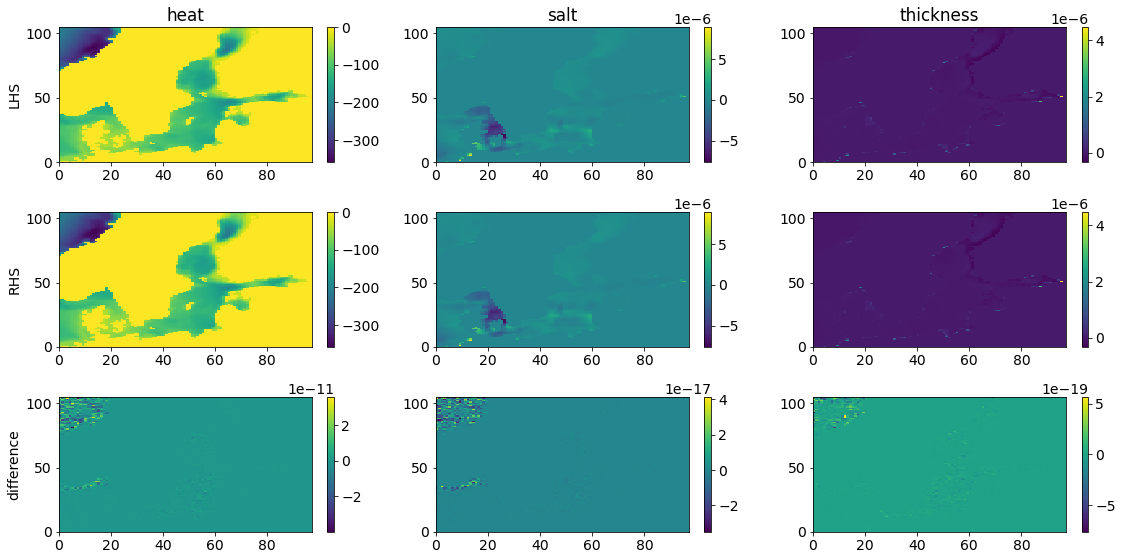

In [14]:
grid = 'native'
# Plot the vertical sum
fig,ax = plt.subplots(figsize=(16,8),nrows=3,ncols=3)
count=0
for key in terms.keys():
    # LHS
    im = ax[0,count].pcolormesh(
        lhs[grid][key].sum(vertind[grid]).squeeze())
    plt.colorbar(im,ax=ax[0,count])
    ax[0,count].set_title(key)
    # RHS
    im = ax[1,count].pcolormesh(
        rhs[grid][key].sum(vertind[grid]).squeeze())
    plt.colorbar(im,ax=ax[1,count])
    # Difference
    im = ax[2,count].pcolormesh(
        (lhs[grid][key]-rhs[grid][key]).sum(vertind[grid]).squeeze())
    plt.colorbar(im,ax=ax[2,count])
    count+=1
ax[0,0].set_ylabel('LHS')
ax[1,0].set_ylabel('RHS')
ax[2,0].set_ylabel('difference')
plt.tight_layout()

#### Local (cell-by-cell) budget closure
It is important to check that the local (cell-by-cell) budget closes, not just that of the full-depth integral. This is because certain processes in the MOM6 algorithm, such as vertical remapping and vertical diffusion, sum to zero in the vertical by construction. Thus, it is possible that those terms could be diagnosed incorrectly, while the full-depth budget remained closed.

We can check that the budget is closed at individual grid cells by looking at a profile at a single location. In this case, it makes sense to define the y-axis as the cumulative thickness of the layers, which defines an approximate depth, and allows like-for-like comparison (particularly when plotting output from different diagnostic grids, as below).  

As before, the difference between the sides of the tracer conservation equation is extremely small compared with either side.

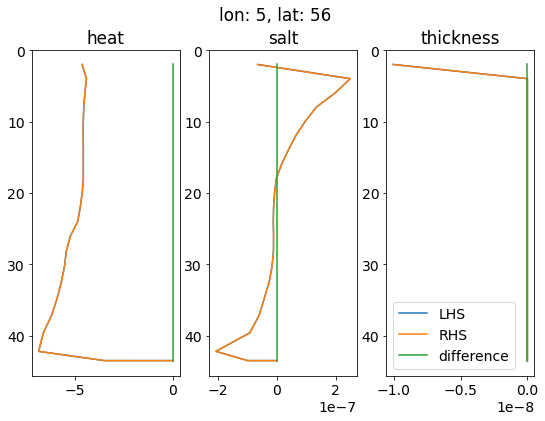

In [15]:
# Plot a profile
# [In this case, plot the terms against the vertical sum of the cell
# thicknesses, so that the y-axis is depth]
lon=5
lat=56
select = {'xh':lon,'yh':lat}
fig,ax = plt.subplots(figsize=(9,6),ncols=3)
count=0
z = ds[grid]['thkcello'].sel(select,method='nearest').squeeze().cumsum(vertind[grid])
for key in terms.keys():
    ax[count].plot(
        lhs[grid][key].sel(select,method='nearest').squeeze(),z,label='LHS')
    ax[count].plot(
        rhs[grid][key].sel(select,method='nearest').squeeze(),z,label='RHS')
    ax[count].plot(
        (lhs[grid][key]-rhs[grid][key]).sel(select,method='nearest').squeeze(),z,label='difference')
    ax[count].invert_yaxis()
    ax[count].set_title(key)
    count+=1
fig.suptitle('lon: '+str(lon)+', lat: '+str(lat))
ax[2].legend()

#### Root-mean-square error
In fact, the most comprehensive way to confirm that the budget is closed is to examine the root-mean-square error (difference) between the sides of the tracer conservation equation. This could be done in any of the $x$, $y$, or $z$, but here we do it in the vertical:

$$ RMSE(i,j) = \sqrt{\sum^{n_k}_{k=1}(LHS(i,j,k)-RHS(i,j,k))^2/n_k}\,,$$

where $k$ is the vertical index.

Again, the RMSE should be around 12 orders of magnitude less than either the left or right hand side terms. By comparison to the vertical sum figure above, it is clear that this is the case.

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


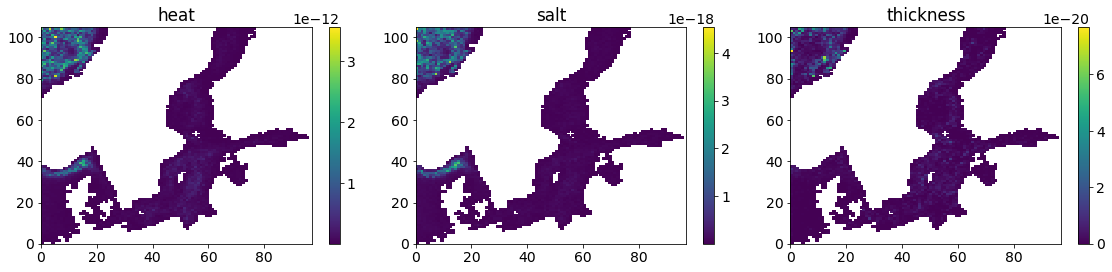

In [16]:
# Calculate the RMSE
rmse = xr.ufuncs.sqrt(xr.ufuncs.square(lhs[grid]-rhs[grid]).mean('zl')).squeeze()
fig,ax = plt.subplots(figsize=(16,4),ncols=3)
count=0
for key in terms.keys():
    im = ax[count].pcolormesh(rmse[key])
    plt.colorbar(im,ax=ax[count])
    ax[count].set_title(key)
    count+=1
plt.tight_layout()

### Diagnostics output on a user-defined vertical grid
Outputting variables on a diagnostic grid is done through a remapping procedure, and it is important to confirm that the procedure does not break the budget closure.  

[TO ADD: More detail on the remapping to diagnostic grids]

#### Local (cell-by-cell) budget closure
We show here a direct, cell-by-cell comparison between the difference arising from diagnostics on the native grid and on the user-defined grids. As above, we plot variables against the cumulative thickness, such that they are defined at the same depth, irrespective of the diagnostic grid.

Here, we can see that the errors are all fairly similary between the different grids and all very small (by comparison to the terms in the profile figure above), implying that the budgets are equivalently closed on the native and diagnostic grids.

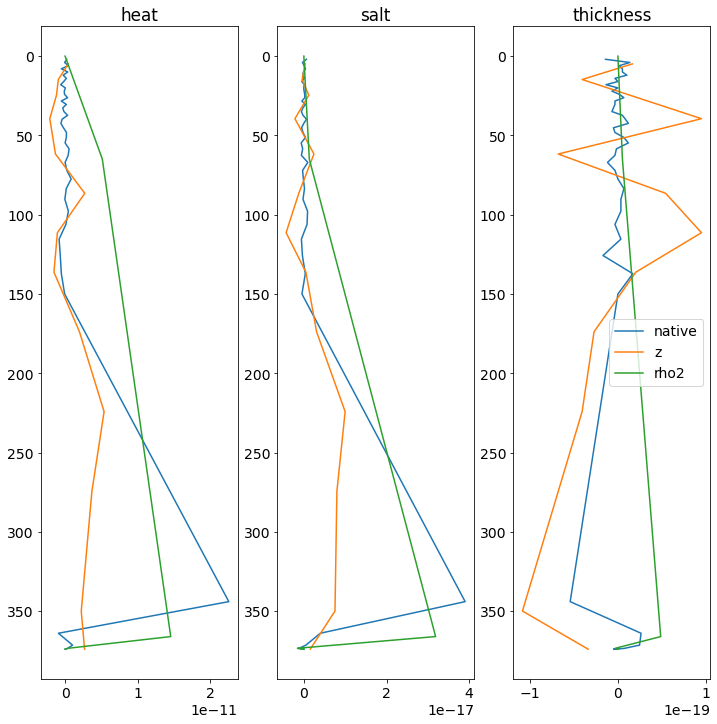

In [17]:
lon=5
lat=90
select = {'xh':lon,'yh':lat}

fig,ax = plt.subplots(figsize=(12,12),ncols=3)
for grid in grids:
    z = ds[grid]['thkcello'].sel(select,method='nearest').squeeze().cumsum(vertind[grid])
    count=0
    for key in terms.keys():
        ax[count].plot(
            (lhs[grid][key]-rhs[grid][key]).sel(select,method='nearest').squeeze(),z,label=grid)
        ax[count].set_title(key)
        count+=1
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()
ax[2].legend()

#### Root-mean-square error
Finally, we compare the RMSE for each of the output grids. On each of the diagnostic grids, the RMSE is small, and comparable to that on the native grid. The errors are very marginally greater on the $z^*$ grid, but still a tiny fraction of the contributing terms.

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


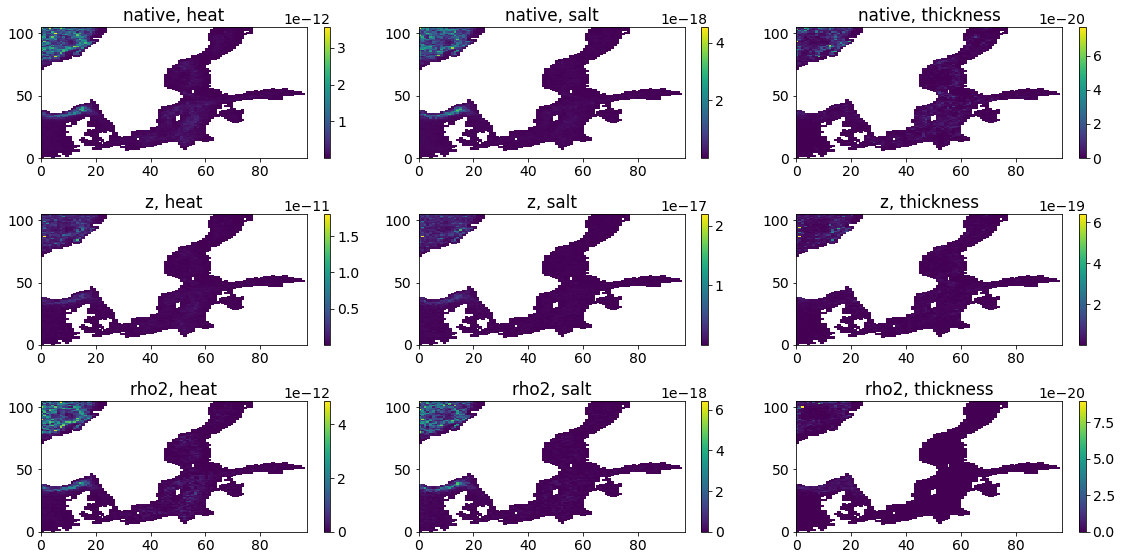

In [18]:
# Plot the vertical sum
fig,ax = plt.subplots(figsize=(16,8),nrows=3,ncols=3)
count_grid=0
for grid in grids:
    # Calculate RMSE
    rmse = xr.ufuncs.sqrt(
        xr.ufuncs.square(lhs[grid]-rhs[grid]).mean(vertind[grid])).squeeze()
    count_key=0
    for key in terms.keys():
        # RMSE
        im = ax[count_grid,count_key].pcolormesh(rmse[key].squeeze())
        plt.colorbar(im,ax=ax[count_grid,count_key])
        ax[count_grid,count_key].set_title(grid+', '+key)
        count_key+=1
    count_grid+=1
plt.tight_layout()